In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xtrack as xt
import xpart as xp
import xobjects as xo
import xcoll as xc
import re

In [17]:
line = xt.Line.from_json('../injection_lines/sps_with_aperture_inj_q20_beam_sagitta4.json')
tt = line.get_table()
tw = line.twiss()

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           


In [3]:
def install_tidp(line, block_mvt=29e-3):
    tidp_ap_tot = 147e-3
    line.discard_tracker()
    tidp = xc.EverestCollimator(length=4.3, material=xc.materials.Carbon, jaw_L= tidp_ap_tot/2 + block_mvt, jaw_R = -tidp_ap_tot/2 + block_mvt)
    line.collimators.install(names=['tidp.11434'], elements=[tidp])
    return tidp

def install_tcsm(line):
    tcsm = xc.EverestCollimator(length=1.83, gap=5, material=xc.materials.Carbon) # length is 1.83
    line.collimators.install(names=['tcsm.51932'], elements=[tcsm])
    return tcsm

In [13]:
def install_offmom_bpms_colls(line, exn=3.5e-6, nrj=21, pmass=0.938, bucket_height=3e-3, n_buckets=2):
    tw = line.twiss()
    tt = line.get_table()
    mask_disp = 5*np.sqrt(tw.betx*exn*pmass/nrj)+n_buckets*bucket_height*tw.dx > 0.025
    mask_bpm = ['bp' in name for name in tt.name]
    mask_aper = np.array(['aper' in name for name in tt.name])
    offmom_bpms = tt.name[mask_disp & mask_bpm & ~mask_aper]
    colls = []
    aper_to_remove = []
    for nn in offmom_bpms:
        aper_to_remove.append(f'{nn}.a_aper')
        aper_to_remove.append(f'{nn}.b_aper')
        if line[nn+'.a_aper'].__class__.__name__ == 'LimitEllipse':
            jaw = line[nn+'.a_aper'].a
        else:
            jaw = line[nn+'.a_aper'].max_x
        
        colls.append(xc.EverestCollimator(length=line[nn].length, material=xc.materials.Beryllium, jaw=jaw))
    line.remove(aper_to_remove)
    line.collimators.install(names=offmom_bpms, elements=colls)
    return colls

In [ ]:
def remove_offmom_bpms_apers(line, exn=3.5e-6, nrj=21, pmass=0.938, bucket_height=3e-3, n_buckets=2):
    "Remove apertures of off-momentum BPMs which give flanges as bottlenecks"
    mask_disp = 5*np.sqrt(tw.betx*exn*pmass/nrj)+n_buckets*bucket_height*tw.dx > 0.025
    mask_bpm = ['bp' in name for name in tt.name]
    mask_aper = np.array(['aper' in name for name in tt.name])
    offmom_bpms = tt.name[mask_disp & mask_bpm & ~mask_aper]
    aper_to_remove = [f'{name}{suffix}' for name in offmom_bpms for suffix in ('.a_aper', '.b_aper')]
    line.remove(aper_to_remove)

In [18]:
remove_offmom_bpms_apers(line, exn=3.5e-6, nrj=21, pmass=0.938, bucket_height=3e-3, n_buckets=2)

# Flanges

## Previous calculations

In [19]:
theta = np.atan(5.3/809)
L1 = 34e-3
L2 = 21e-3
L3 = 754e-3
h_tot = 5.3e-3

x1 = L1/np.cos(theta)
x2 = L2/np.cos(theta)
x3 = L3/np.cos(theta)

print(np.sin(theta)*(x1+x2+x3), h_tot)

x_tot = x1+x2+x3
w_steel = x1/x_tot
w_air = (x2+x3)/x_tot

print(w_steel, w_air)

0.0053 0.0053
0.04202719406674908 0.9579728059332508


In [20]:
d_steel_air = x2+x3

X_Be = 35.28e-2
X_air = 303.9
X_Fe = 1.757e-2
X_C = 19.32e-2
X_steel = (0.02/X_C + 0.98/X_Fe)**(-1)
X_steel_air = (w_steel/X_steel + w_air/X_air)**(-1)

d_Be = X_Be/X_steel_air * d_steel_air #shorter than d_steel_air so we can keep angle theta and stop collimator before end of VCAK

In [21]:
tt = line.get_table()

In [22]:
tt.rows['vcak.*']

Table: 62 rows, 11 cols
name                          s element_type isthick isreplica parent_name iscollective ...
vcak.10101.a_aper       29.8516 LimitEllipse   False     False None               False
vcak.10101.b_aper       30.1487 LimitEllipse   False     False None               False
vcak.11101.a_aper       349.828 LimitEllipse   False     False None               False
vcak.11101.b_aper       350.687 LimitEllipse   False     False None               False
vcak.11301.a_aper       413.824 LimitEllipse   False     False None               False
vcak.11301.b_aper       414.121 LimitEllipse   False     False None               False
vcak.12501.a_aper       797.796 LimitEllipse   False     False None               False
vcak.12501.b_aper       798.655 LimitEllipse   False     False None               False
vcak.13501.a_aper       1117.77 LimitEllipse   False     False None               False
vcak.13501.b_aper       1118.63 LimitEllipse   False     False None               False
...


In [23]:
line['vcak.10101.a_aper']

View of LimitEllipse(a=0.0415, b=0.0415)

In [24]:
tt.rows['vebb.*']

Table: 768 rows, 11 cols
name                          s element_type isthick isreplica parent_name iscollective ...
vebb.10070.a_aper       16.5716 LimitRect      False     False None               False
vebb.10070.b_aper       23.2104 LimitRect      False     False None               False
vebb.10090.a_aper       23.2116 LimitRect      False     False None               False
vebb.10090.b_aper       29.8504 LimitRect      False     False None               False
vebb.10130.a_aper       35.2493 LimitRect      False     False None               False
vebb.10130.b_aper       41.8881 LimitRect      False     False None               False
vebb.10150.a_aper       41.8893 LimitRect      False     False None               False
vebb.10150.b_aper       48.5281 LimitRect      False     False None               False
vebb.10270.a_aper        80.567 LimitRect      False     False None               False
vebb.10270.b_aper       87.2058 LimitRect      False     False None               False
...

In [25]:
line['vebb.10090.b_aper']

View of LimitRect(min_x=-0.0645, max_x=0.0645, min_y=-0.0267, max_y=0.0267, _sin_rot_s=-999, _cos_rot_s=-999, _shift_x=0, _shift_y=0, _shift_s=0, _rot_x_rad=0, _rot_y_rad=0, _rot_s_rad_no_frame=0, rot_shift_anchor=0)

In [26]:
tt.rows['vcad.*']

Table: 124 rows, 11 cols
name                          s element_type isthick isreplica parent_name iscollective ...
vcad.10301.a_aper       93.8467 LimitEllipse   False     False None               False
vcad.10301.b_aper       94.7055 LimitEllipse   False     False None               False
vcad.10501.a_aper       157.842 LimitEllipse   False     False None               False
vcad.10501.b_aper       159.263 LimitEllipse   False     False None               False
vcad.10702.a_aper       221.838 LimitEllipse   False     False None               False
vcad.10702.b_aper       222.696 LimitEllipse   False     False None               False
vcad.10901.a_aper       285.833 LimitEllipse   False     False None               False
vcad.10901.b_aper       287.254 LimitEllipse   False     False None               False
vcad.11501.a_aper        477.82 LimitEllipse   False     False None               False
vcad.11501.b_aper       478.679 LimitEllipse   False     False None               False
...

In [27]:
line['vcad.10301.a_aper']

View of LimitEllipse(a=0.0415, b=0.0415)

In [28]:
import apertls

In [29]:
ap_calc = apertls.ApertureCalculator(line)
x_ext = ap_calc.compute_x_extent()

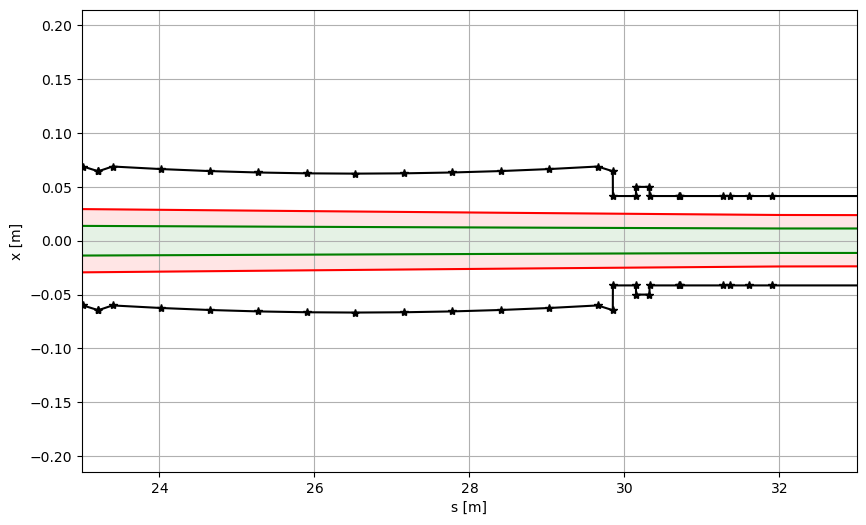

In [47]:
exn=3.5e-6
nrj=21
pmass=0.938
bucket_height=3e-3
n_buckets = 1

mask = np.array([line[nn].__class__.__name__.startswith('Limit') for nn in tt.name[:-1]])
mask = np.concatenate((mask, [False]))
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(tt.s[mask], x_ext[:, 0], '*-', color='k')
ax.plot(tt.s[mask], x_ext[:, 1], '*-', color='k')
ax.plot(tw.s, 5*np.sqrt(tw.betx*exn*pmass/nrj), color='green', label='5 sigma')
ax.plot(tw.s, -5*np.sqrt(tw.betx*exn*pmass/nrj), color='green')

ax.plot(tw.s, 5*np.sqrt(tw.betx*exn*pmass/nrj)+n_buckets*bucket_height*tw.dx, color='red', label='5 sigma + bucket')
ax.plot(tw.s, -5*np.sqrt(tw.betx*exn*pmass/nrj)-n_buckets*bucket_height*tw.dx, color='red')

ax.fill_between(tw.s, -5*np.sqrt(tw.betx*exn*pmass/nrj), 5*np.sqrt(tw.betx*exn*pmass/nrj), color='green', alpha=0.1)
ax.fill_between(tw.s, -5*np.sqrt(tw.betx*exn*pmass/nrj)-n_buckets*bucket_height*tw.dx, -5*np.sqrt(tw.betx*exn*pmass/nrj), color='red', alpha=0.1)
ax.fill_between(tw.s, 5*np.sqrt(tw.betx*exn*pmass/nrj)+n_buckets*bucket_height*tw.dx, 5*np.sqrt(tw.betx*exn*pmass/nrj), color='red', alpha=0.1)
ax.grid()
# ax.legend()
ax.set_xlim(23,33)
ax.set_xlabel('s [m]')
ax.set_ylabel('x [m]')
ax.hlines(0.02, 5200, 6200)
# plt.savefig('x_extent_with_bucket.pdf', dpi=300)
plt.show()

In [57]:
mask_s = (tw.s>23) & (tw.s<33)
mask_aper = np.array([line[nn].__class__.__name__.startswith('Limit') for nn in tt.name[:-1]])
mask_aper = np.concatenate((mask_aper, [False]))

In [41]:
tt = line.get_table()
tw = line.twiss()

In [59]:
tt.rows[tt.name[mask_s &mask_aper]]

Table: 26 rows, 11 cols
name                            s element_type isthick isreplica parent_name iscollective ...
mbb.10070..10_aper2        23.015 LimitRect      False     False None               False
vebb.10070.b_aper         23.2104 LimitRect      False     False None               False
vebb.10090.a_aper         23.2116 LimitRect      False     False None               False
mbb.10090..0_aper2         23.395 LimitRect      False     False None               False
mbb.10090..1_aper2         24.021 LimitRect      False     False None               False
mbb.10090..2_aper2         24.647 LimitRect      False     False None               False
mbb.10090..3_aper2         25.273 LimitRect      False     False None               False
mbb.10090..4_aper2         25.899 LimitRect      False     False None               False
mbb.10090..5_aper2         26.525 LimitRect      False     False None               False
mbb.10090..6_aper2         27.151 LimitRect      False     False None   

In [60]:
line['veqd.10110.a_aper']

View of LimitEllipse(a=0.0415, b=0.0415)

In [61]:
85-62

23